<a href="https://colab.research.google.com/github/Wooshaw/ESE_527_Project/blob/main/Stock_Price_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stock Price Prediction Model**

We plan to build a long-short-term memory (LSTM) network to predict the day price direction of stocks. We will compare our model with 4 selected machine learning-based benchmarks, including 1. logistic regression, 2. decision tree, 3. random forest, and 4. Gradient boosting ensemble, on 5 to 10 stocks from Yahoo Finance.

In [ ]:
# pip install yfinance

import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import datetime as dt
import copy


# Getting the Data

In [ ]:
df_BRK = yf.Ticker("BRK-A").history(period="max")

df_BRK.reset_index(inplace=True) # Make date no longer an Index

df_BRK.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1980-03-17 00:00:00-05:00,290.0,310.0,290.0,290.0,10000,0.0,0.0
1,1980-03-18 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
2,1980-03-19 00:00:00-05:00,290.0,310.0,290.0,290.0,20000,0.0,0.0
3,1980-03-20 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
4,1980-03-21 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0


In [ ]:
def analyze(dataframe):
    """Runs an exploration analysis of the dataframe."""
    print("The Shape of the dataset is", dataframe.shape, "\n")
    print("The columns of the dataset consists of", dataframe.columns, "\n")
    dataframe.info()
    print("\n", dataframe.describe(), "\n")

In [ ]:
def plot(dataframe):
  """Draws a graph of price movements"""
  print("The data ranges from", dataframe["Date"].min(), "to", dataframe["Date"].max())
  dataframe.plot(x="Date", y=["Close", "Open", "High", "Low"])

In [ ]:
analyze(df_BRK)

Shape (10978, 8) 

Columns Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10978 entries, 0 to 10977
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          10978 non-null  datetime64[ns, America/New_York]
 1   Open          10978 non-null  float64                         
 2   High          10978 non-null  float64                         
 3   Low           10978 non-null  float64                         
 4   Close         10978 non-null  float64                         
 5   Volume        10978 non-null  int64                           
 6   Dividends     10978 non-null  float64                         
 7   Stock Splits  10978 non-null  float64                         
dtypes: datetime64[ns, America/New_York](1), float64(6), int64(1)
m

The data ranges from 2015-10-20 00:00:00-04:00 to 2023-09-29 00:00:00-04:00


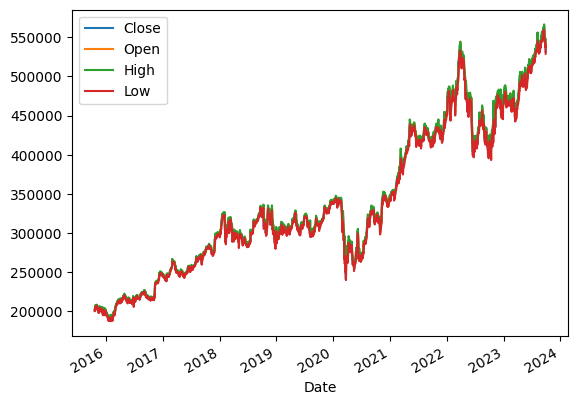

In [ ]:
plot(df_BRK.iloc[-2000:,:])

As noticeable, around March 2020, we see a sudden drop in the price, after which it reports steady growth until recently.

It will be challenging for a model in the stock prediction using machine learning project to correctly estimate the rapid changes that we can see in March 2020 and February 2022. We will focus on evaluating the model performance in predicting the more recent values after training it on the past data.

Similarly, plotting the Open and Close value of the stock for each day gives equivalent observations.

# Data Exploration & Visualization

Plot for Close, Open, High, and Low prices.

The data ranges from 2023-05-09 00:00:00-04:00 to 2023-09-29 00:00:00-04:00


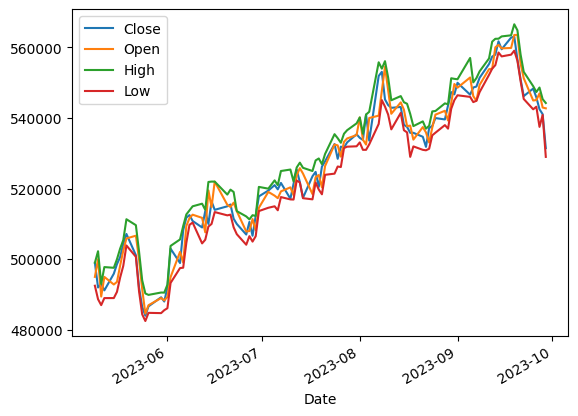

In [ ]:
plot(df_BRK.iloc[-100:,:])

The volatility of 3 days, 7 days, 14 days window, which measures how much stock price moves

<Axes: xlabel='Date'>

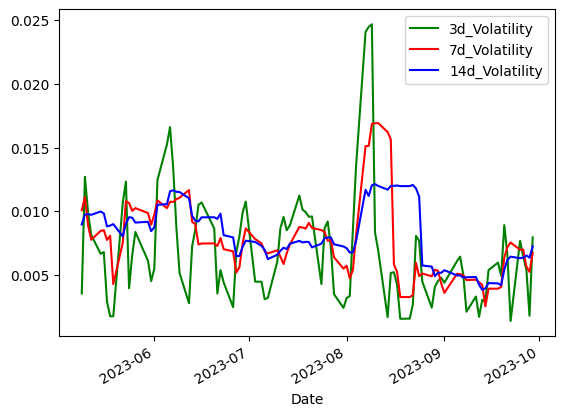

In [ ]:
volatility_frame = copy.deepcopy(df_BRK[['Date','Close']])
volatility_frame['Daily_Return'] = volatility_frame['Close'].pct_change()
volatility_frame['3d_Volatility'] = volatility_frame['Daily_Return'].rolling(window=3).std()
volatility_frame['7d_Volatility'] = volatility_frame['Daily_Return'].rolling(window=7).std()
volatility_frame['14d_Volatility'] = volatility_frame['Daily_Return'].rolling(window=14).std()
volatility_frame.iloc[-100:,:].plot(x="Date", y=["3d_Volatility","7d_Volatility","14d_Volatility"],color=['green','red','blue'])

The Lagged Scatter plot of 1 days, 3 days, 7 days window, which measures how the value of the stock price today relates to its value on the previous day(s)

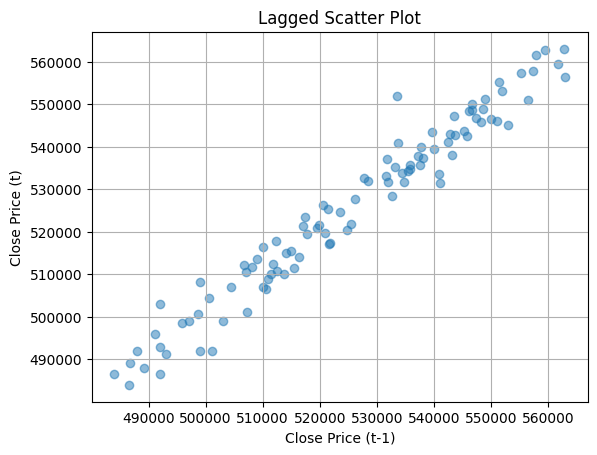

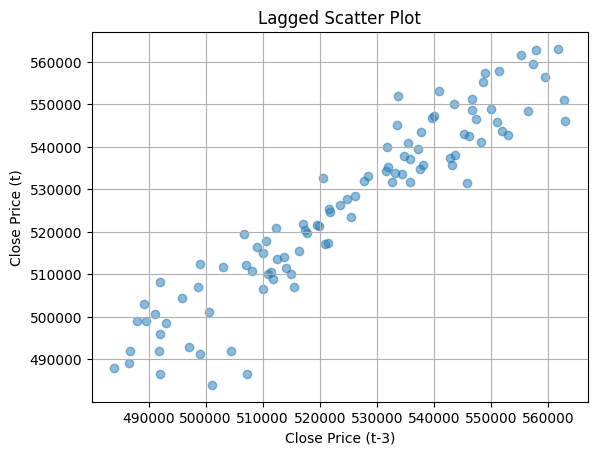

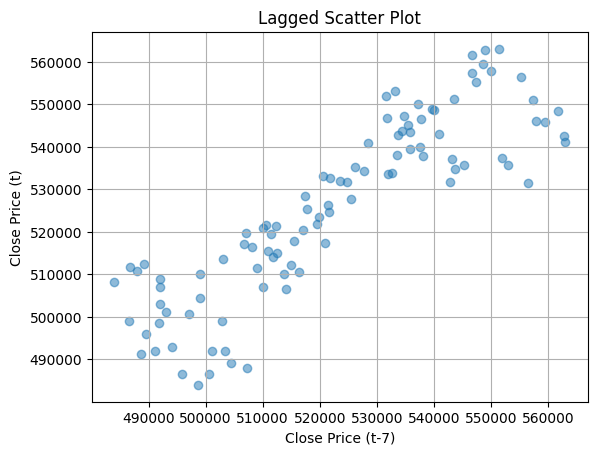

In [ ]:
lag_frame = copy.deepcopy(df_BRK[['Date','Close']])
lag_frame['1d_Lagged_Close'] = lag_frame['Close'].shift(1)
lag_frame['3d_Lagged_Close'] = lag_frame['Close'].shift(3)
lag_frame['7d_Lagged_Close'] = lag_frame['Close'].shift(7)


plt.scatter(lag_frame.iloc[-100:,:]['1d_Lagged_Close'], lag_frame.iloc[-100:,:]['Close'], alpha=0.5)
plt.title('Lagged Scatter Plot')
plt.xlabel(f'Close Price (t-{1})')
plt.ylabel('Close Price (t)')
plt.grid(True)
plt.show()

plt.scatter(lag_frame.iloc[-100:,:]['3d_Lagged_Close'], lag_frame.iloc[-100:,:]['Close'], alpha=0.5)
plt.title('Lagged Scatter Plot')
plt.xlabel(f'Close Price (t-{3})')
plt.ylabel('Close Price (t)')
plt.grid(True)
plt.show()

plt.scatter(lag_frame.iloc[-100:,:]['7d_Lagged_Close'], lag_frame.iloc[-100:,:]['Close'], alpha=0.5)
plt.title('Lagged Scatter Plot')
plt.xlabel(f'Close Price (t-{7})')
plt.ylabel('Close Price (t)')
plt.grid(True)
plt.show()

The average plot of 3 days, 7 days, 14 days window, which smooth the stock price and show us the long-term trends.

<Axes: xlabel='Date'>

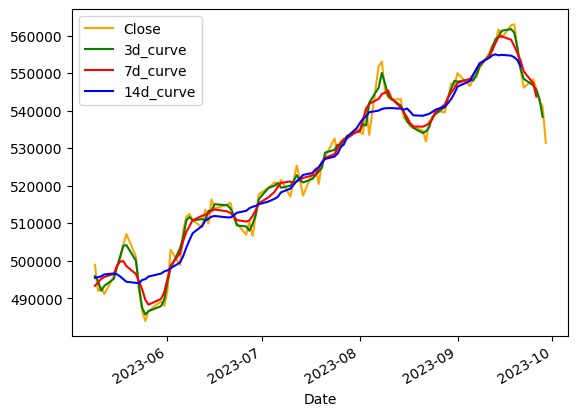

In [ ]:
close_frame = copy.deepcopy(df_BRK[['Date','Close']])
close_frame["3d_curve"] = close_frame['Close'].rolling(window=3, center=True).mean()
close_frame["7d_curve"] = close_frame['Close'].rolling(window=7, center=True).mean()
close_frame["14d_curve"] = close_frame['Close'].rolling(window=14, center=True).mean()
close_frame.iloc[-100:,:].plot(x="Date", y=["Close","3d_curve","7d_curve","14d_curve"],color=['orange','green','red','blue'])

# Feature Engineering

Bring previous price into today's price

In [ ]:
featured_frame = copy.deepcopy(df_BRK)
featured_frame['1d_Close'] = featured_frame['Close'].shift(1)
featured_frame['3d_Close'] = featured_frame['Close'].shift(3)
featured_frame['7d_Close'] = featured_frame['Close'].shift(7)
featured_frame.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,1d_Close,3d_Close,7d_Close
10973,2023-09-25 00:00:00-04:00,544977.0,549032.0,542482.0,548360.0,9500,0.0,0.0,546215.0,556580.0,561740.0
10974,2023-09-26 00:00:00-04:00,545104.0,547380.0,543213.0,545870.0,7300,0.0,0.0,548360.0,551030.0,559500.0
10975,2023-09-27 00:00:00-04:00,546982.0,548652.0,537500.0,542495.0,7900,0.0,0.0,545870.0,546215.0,562800.0
10976,2023-09-28 00:00:00-04:00,542978.0,545360.0,540875.0,541105.0,7000,0.0,0.0,542495.0,548360.0,563073.0
10977,2023-09-29 00:00:00-04:00,542758.0,544264.0,529000.0,531477.0,8800,0.0,0.0,541105.0,545870.0,556580.0


The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. RSI oscillates between zero and 100 and is often used to identify overbought or oversold conditions in a traded security.

In [ ]:
def compute_rsi(data, window=14):
    delta = data.diff()
    delta = delta.dropna()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    avg_gain = up.rolling(window=window, min_periods=1).mean()
    avg_loss = -down.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

featured_frame['RSI'] = compute_rsi(featured_frame['Close'])
featured_frame.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,1d_Close,3d_Close,7d_Close,RSI
10973,2023-09-25 00:00:00-04:00,544977.0,549032.0,542482.0,548360.0,9500,0.0,0.0,546215.0,556580.0,561740.0,52.170102
10974,2023-09-26 00:00:00-04:00,545104.0,547380.0,543213.0,545870.0,7300,0.0,0.0,548360.0,551030.0,559500.0,46.545833
10975,2023-09-27 00:00:00-04:00,546982.0,548652.0,537500.0,542495.0,7900,0.0,0.0,545870.0,546215.0,562800.0,42.601918
10976,2023-09-28 00:00:00-04:00,542978.0,545360.0,540875.0,541105.0,7000,0.0,0.0,542495.0,548360.0,563073.0,37.855492
10977,2023-09-29 00:00:00-04:00,542758.0,544264.0,529000.0,531477.0,8800,0.0,0.0,541105.0,545870.0,556580.0,25.242053


Bollinger Bands are a volatility indicator that consists of a middle band being an N-period simple moving average (SMA), an upper band at K times an N-period standard deviation above the middle band, and a lower band at K times an N-period standard deviation below the middle band.

In [ ]:
featured_frame['SMA'] = featured_frame['Close'].rolling(window=20).mean()
featured_frame['STD'] = featured_frame['Close'].rolling(window=20).std()
featured_frame['Upper_BB'] = featured_frame['SMA'] + (featured_frame['STD'] * 2)
featured_frame['Lower_BB'] = featured_frame['SMA'] - (featured_frame['STD'] * 2)
featured_frame.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,1d_Close,3d_Close,7d_Close,RSI,SMA,STD,Upper_BB,Lower_BB
10973,2023-09-25 00:00:00-04:00,544977.0,549032.0,542482.0,548360.0,9500,0.0,0.0,546215.0,556580.0,561740.0,52.170102,552143.50,6735.248978,565613.997955,538673.002045
10974,2023-09-26 00:00:00-04:00,545104.0,547380.0,543213.0,545870.0,7300,0.0,0.0,548360.0,551030.0,559500.0,46.545833,552456.75,6249.582326,564955.914652,539957.585348
10975,2023-09-27 00:00:00-04:00,546982.0,548652.0,537500.0,542495.0,7900,0.0,0.0,545870.0,546215.0,562800.0,42.601918,552401.85,6335.773224,565073.396448,539730.303552
10976,2023-09-28 00:00:00-04:00,542978.0,545360.0,540875.0,541105.0,7000,0.0,0.0,542495.0,548360.0,563073.0,37.855492,552089.70,6738.839086,565567.378171,538612.021829
10977,2023-09-29 00:00:00-04:00,542758.0,544264.0,529000.0,531477.0,8800,0.0,0.0,541105.0,545870.0,556580.0,25.242053,551327.30,8102.323943,567531.947886,535122.652114
